<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>



<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/GeoDataFrame_SpatialOperation/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Basic spatial operations in  Geo Dataframes

We will review some important operations for geodataframes.

Let's remember the contents of the world map from last session:

<a class="anchor" id="0"></a>

In [1]:
linkWorldMap="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/WORLD/worldMaps.gpkg"

import geopandas as gpd
gpd.list_layers(linkWorldMap)

,name,geometry_type
0,rivers,MultiLineString
1,cities,Point
2,countries,MultiPolygon


Let's open all the layers (this takes a minute):

In [2]:
countries=gpd.read_file(linkWorldMap,layer='countries')
rivers=gpd.read_file(linkWorldMap,layer='rivers')
cities=gpd.read_file(linkWorldMap,layer='cities')



Now, let's see some important spatial operations.


<a class="anchor" id="1"></a>

# Subsetting

## Filtering

You can keep some elements by subsetting by *filtering*, as we used to do in common pandas data frames.

In [3]:
countries.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"MULTIPOLYGON (((-69.88223 12.41111, -69.94695 ..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
3,Algeria,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


In [4]:
# as DF
countries.iloc[50:,]

,COUNTRY,geometry
50,Central African Republic,"MULTIPOLYGON (((20.4533 4.52379, 20.45798 4.61..."
51,Cuba,"MULTIPOLYGON (((-76.94608 21.45221, -76.8839 2..."
52,Cape Verde,"MULTIPOLYGON (((-25.28139 16.91333, -25.29861 ..."
53,Cook Islands (New Zealand),"MULTIPOLYGON (((-165.84167 -10.89084, -165.848..."
54,Cyprus,"MULTIPOLYGON (((33.27229 34.70955, 33.21722 34..."
...,...,...
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -..."
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ..."


In [5]:
# as DF
countries.loc[50:,'geometry']

50     MULTIPOLYGON (((20.4533 4.52379, 20.45798 4.61...
51     MULTIPOLYGON (((-76.94608 21.45221, -76.8839 2...
52     MULTIPOLYGON (((-25.28139 16.91333, -25.29861 ...
53     MULTIPOLYGON (((-165.84167 -10.89084, -165.848...
54     MULTIPOLYGON (((33.27229 34.70955, 33.21722 34...
                             ...                        
247    MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9...
248    MULTIPOLYGON (((123.21846 -10.80917, 123.19832...
249    MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -...
250    MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ...
251    MULTIPOLYGON (((-68.19736 12.22264, -68.19292 ...
Name: geometry, Length: 202, dtype: geometry

But as a GeDF, you can also filter using a coordinate point via __cx__. Let me get the bounding box of the map:

In [6]:
countries.total_bounds

array([-180.        ,  -90.        ,  180.        ,   83.62359619])

As you are getting __[minx, miny, maxx, maxy]__ let me select a valid coordinate, i.e. (0,0)

In [7]:
countries.cx[:0,:0]

,COUNTRY,geometry
9,American Samoa (US),"MULTIPOLYGON (((-170.7439 -14.37556, -170.7494..."
10,Argentina,"MULTIPOLYGON (((-71.01648 -36.47591, -70.98195..."
14,Antarctica,"MULTIPOLYGON (((-45.14528 -60.76611, -45.15639..."
24,Bolivia,"MULTIPOLYGON (((-62.19884 -20.47139, -62.26945..."
29,Brazil,"MULTIPOLYGON (((-70.62862 -9.94849, -70.62889 ..."
42,Chile,"MULTIPOLYGON (((-73.61806 -51.6339, -73.60494 ..."
47,Colombia,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
53,Cook Islands (New Zealand),"MULTIPOLYGON (((-165.84167 -10.89084, -165.848..."
58,Jarvis Island (US),"MULTIPOLYGON (((-160.02115 -0.39806, -160.0281..."
60,Ecuador,"MULTIPOLYGON (((-78.70903 -4.58479, -78.72348 ..."


<Axes: >

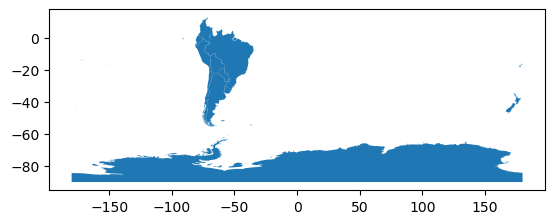

In [8]:
#then
countries.cx[:0,:0].plot()

Notice __cx__ would be cleaner if spatial element is a point.

## Clipping

Let me keep one country:

In [9]:
brazil=countries[countries.COUNTRY=='Brazil']
#see
brazil

,COUNTRY,geometry
29,Brazil,"MULTIPOLYGON (((-70.62862 -9.94849, -70.62889 ..."


Pay attention to this GDF:

In [10]:
cities

,NAME,COUNTRY,CAPITAL,geometry
0,Murmansk,Russia,N,POINT (33.08604 68.96355)
1,Arkhangelsk,Russia,N,POINT (40.64616 64.52067)
2,Saint Petersburg,Russia,N,POINT (30.45333 59.95189)
3,Magadan,Russia,N,POINT (150.78001 59.571)
4,Perm',Russia,N,POINT (56.23246 58.00024)
...,...,...,...,...
605,Singapore,Singapore,N,POINT (103.82688 1.34654)
606,Gaza,Palestine,N,POINT (34.41939 31.46288)
607,Juba,South Sudan,Y,POINT (31.76671 4.57511)
608,Dili,East Timor,Y,POINT (125.67275 -8.56601)


The GDF has a column 'COUNTRY' too.

Now, check the rivers GDF:

In [11]:
rivers

,NAME,SYSTEM,geometry
0,Aldan,Lena,"MULTILINESTRING ((124.00678 56.47258, 123.2595..."
1,Amazon,Amazon,"MULTILINESTRING ((-61.2773 -3.60706, -60.68466..."
2,Amu Darya,None,"MULTILINESTRING ((73.98818 37.49952, 73.52595 ..."
3,Amur,None,"MULTILINESTRING ((122.63956 49.9973, 120.47874..."
4,Angara,None,"MULTILINESTRING ((105.07841 51.93053, 103.9295..."
...,...,...,...
93,Yangtze,None,"MULTILINESTRING ((119.82609 32.24864, 118.9707..."
94,Yenisey,None,"MULTILINESTRING ((98.94706 52.57675, 98.12095 ..."
95,Yukon,None,"MULTILINESTRING ((-130.89319 59.2448, -131.065..."
96,Zambezi,None,"MULTILINESTRING ((35.52866 -17.66773, 36.28055..."


As you see, this GDF has no Country. But since it has geometry, you can keep the rivers, or their sections, that serve a country:

In [12]:
riversBrazil_clipped = gpd.clip(gdf=rivers,
                               mask=brazil)

Then, you can plot the clipped version:

<Axes: >

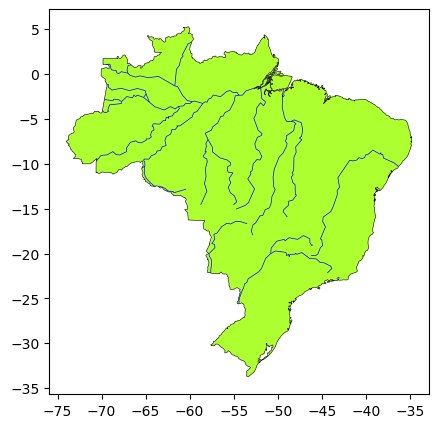

In [13]:
base = brazil.plot(facecolor="greenyellow", edgecolor='black', linewidth=0.4,figsize=(5,5))
riversBrazil_clipped.plot(edgecolor='blue', linewidth=0.5,
                    ax=base)

The geometry types are not modified:

In [14]:
set(brazil.geom_type), set(riversBrazil_clipped.geom_type)

({'MultiPolygon'}, {'LineString', 'MultiLineString'})

[TOC](#0)

_____________


<a class="anchor" id="3"></a>

# UNARY Operations on GeoDF

Let me bring the projected data from Brazil.

In [15]:
LinkBrazil="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/BRAZIL/brazil_5880.gpkg"
## we have
gpd.list_layers(LinkBrazil)

,name,geometry_type
0,country,MultiPolygon
1,cities,Point
2,airports,Point
3,states,MultiPolygon
4,municipalities,MultiPolygon


Let me open municipalities:

<Axes: >

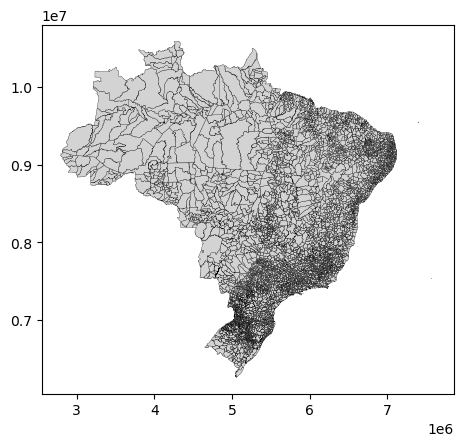

In [16]:
brazil_municipalities=gpd.read_file(LinkBrazil,layer='municipalities')
brazil_municipalities.plot(facecolor='lightgrey', edgecolor='black',linewidth=0.2)

In [17]:
#see
brazil_municipalities.head()

,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE,ADM2_PT,ADM2_PCODE,ET_ID,geometry
0,Brazil,Brasil,BR,Rondônia,BR11,Alta Floresta D'Oeste,BR1100015,0,"MULTIPOLYGON (((4123083.754 8674925.499, 41235..."
1,Brazil,Brasil,BR,Rondônia,BR11,Ariquemes,BR1100023,1,"MULTIPOLYGON (((4076081.319 8904169.38, 407563..."
2,Brazil,Brasil,BR,Rondônia,BR11,Cabixi,BR1100031,2,"MULTIPOLYGON (((4309820.991 8508152.337, 43098..."
3,Brazil,Brasil,BR,Rondônia,BR11,Cacoal,BR1100049,3,"MULTIPOLYGON (((4234969.465 8775486.145, 42351..."
4,Brazil,Brasil,BR,Rondônia,BR11,Cerejeiras,BR1100056,4,"MULTIPOLYGON (((4218593.898 8541471.292, 42189..."


In [18]:
## we have
len(brazil_municipalities.ADM2_PT)

5572

In [19]:
# higher level count
len(set(brazil_municipalities.ADM1_PT))

27

Then, this is Minas Gerais:

<Axes: >

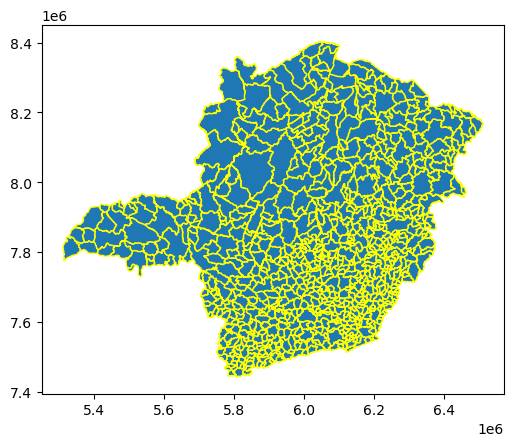

In [20]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].plot(edgecolor='yellow')

## I. Operation that combine 

Let's see the options to combine:

### Unary UNION

We can combine all these polygons into one:

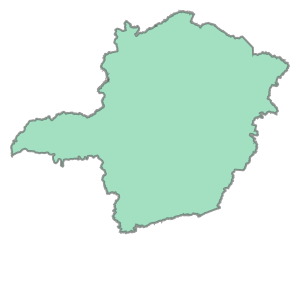

In [21]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].union_all()

Let's save that result:

In [22]:
MinasGerais_union=brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].union_all()

In [23]:
# what do we have?
type(MinasGerais_union)

shapely.geometry.multipolygon.MultiPolygon

You can turn that shapely object into a GeoDF like this:

In [24]:
gpd.GeoDataFrame(index=[0], # one element
                 data={'ADM':'Minas Gerais'}, # the column and the value
                 crs=brazil_municipalities.crs,
                 geometry=[MinasGerais_union]) # the recent union

,ADM,geometry
0,Minas Gerais,"MULTIPOLYGON (((5785356.379 7461893.959, 57847..."


<a class="anchor" id="21"></a>

### Dissolve

#### a. Dissolve as Union
Using  **dissolve** is an alternative to _UNION_:

<Axes: >

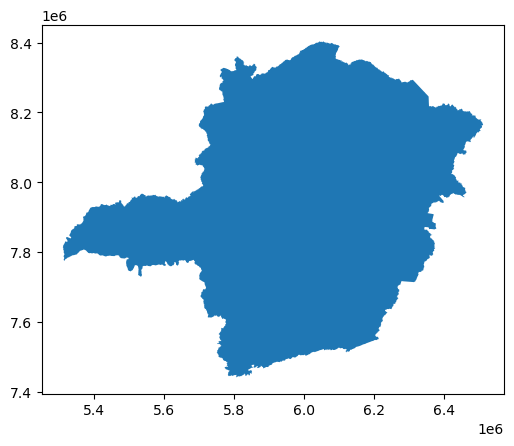

In [25]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].dissolve().plot()

Let me save the result, and see the type :

In [26]:
MinasGerais_dissolve=brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].dissolve()

# we got?
type(MinasGerais_dissolve)

geopandas.geodataframe.GeoDataFrame

You got a GEOdf this time:

In [27]:
## see
MinasGerais_dissolve

,geometry,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE,ADM2_PT,ADM2_PCODE,ET_ID
0,"MULTIPOLYGON (((5785356.379 7461893.959, 57847...",Brazil,Brasil,BR,Minas Gerais,BR31,Abadia dos Dourados,BR3100104,2244


In [28]:
# keeping what is relevant
MinasGerais_dissolve.drop(columns=['ADM2_PT','ADM2_PCODE','ET_ID'],inplace=True)

# then
MinasGerais_dissolve

,geometry,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE
0,"MULTIPOLYGON (((5785356.379 7461893.959, 57847...",Brazil,Brasil,BR,Minas Gerais,BR31


#### b. Dissolve for groups

Using _dissolve()_ with no arguments returns the union of the polygons, BUT also you get a GEOdf.
However, if you have a column that represents a grouping (as we do), you can dissolve by that column:

<Axes: >

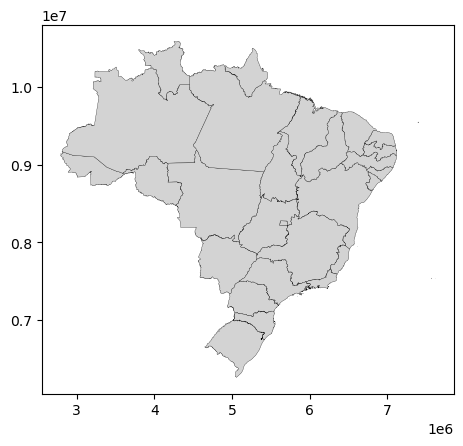

In [29]:
# dissolving
brazil_municipalities.dissolve(by='ADM1_PT').plot(facecolor='lightgrey', edgecolor='black',linewidth=0.2)

Again, let me save this result:

In [30]:
Brazil_adm1_diss=brazil_municipalities.dissolve(by='ADM1_PT')

We know we have a GeoDF; let's see contents:

In [65]:
Brazil_adm1_diss.head()

,ADM1_PT,geometry,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PCODE
0,Acre,"MULTIPOLYGON (((3314561.941 8748537.521, 33145...",Brazil,Brasil,BR,BR12
1,Alagoas,"POLYGON ((6867433.311 8839059.282, 6867224.999...",Brazil,Brasil,BR,BR27
2,Amapá,"MULTIPOLYGON (((5243842.447 9871959.688, 52428...",Brazil,Brasil,BR,BR16
3,Amazonas,"MULTIPOLYGON (((3230169.545 9098328.273, 32298...",Brazil,Brasil,BR,BR13
4,Bahia,"MULTIPOLYGON (((6222869.527 8316183.361, 62224...",Brazil,Brasil,BR,BR29


Again, we can drop columns that do not bring important information:

In [32]:
Brazil_adm1_diss.drop(columns=['ADM2_PT','ADM2_PCODE','ET_ID'],inplace=True)
Brazil_adm1_diss.reset_index(inplace=True)
Brazil_adm1_diss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADM1_PT     27 non-null     object  
 1   geometry    27 non-null     geometry
 2   ADM0_EN     27 non-null     object  
 3   ADM0_PT     27 non-null     object  
 4   ADM0_PCODE  27 non-null     object  
 5   ADM1_PCODE  27 non-null     object  
dtypes: geometry(1), object(5)
memory usage: 1.4+ KB


#### c. Dissolve and aggregate

In pandas, you can aggregate data using some statistics. Let me open the map with indicators we created in a previous session:

In [66]:
linkInd="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/WORLD/worldindicators.json"
indicators=gpd.read_file(linkInd)
indicators.head()

,Country,iso2,iso3,region,fragility,co2,sq_km,num_airports,population,mobiles,geometry
0,ANTIGUA AND BARBUDA,AG,ATG,CENTRAL AMERICA AND THE CARIBBEAN,54.4,729000,443,4,102634,184000,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
1,AFGHANISTAN,AF,AFG,SOUTH ASIA,105.0,7893000,652230,68,40121552,23000000,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
2,ALGERIA,DZ,DZA,AFRICA,75.4,151633000,2381740,95,47022473,51500000,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
3,AZERBAIJAN,AZ,AZE,MIDDLE EAST,73.2,35389000,86600,32,10650239,11000000,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
4,ALBANIA,AL,ALB,EUROPE,58.9,3794000,28748,3,3107100,2610000,"MULTIPOLYGON (((20.79192 40.43154, 20.78722 40..."


You can compute the mean of the countries by region, using a DF approach like this:

In [67]:
indicators.groupby('region').agg({'fragility':'mean'})

,fragility
region,
AFRICA,85.664706
AUSTRALIA AND OCEANIA,60.471429
CENTRAL AMERICA AND THE CARIBBEAN,62.993750
CENTRAL ASIA,72.883333
EAST AND SOUTHEAST ASIA,64.120000
EUROPE,40.418919
MIDDLE EAST,71.756250
NORTH AMERICA,42.566667
SOUTH AMERICA,63.816667



The RESULT is just data, you see no spatial information. It got lost.

The appropriate operation to conserve spatial information is **Dissolve**:

In [68]:
indicatorsByRegion=indicators.dissolve(
     by="region",
     aggfunc={
         "fragility": ["mean"]},as_index=False, grid_size=0.1
 )

## see the spatial info
indicatorsByRegion

,region,geometry,"(fragility, mean)"
0,AFRICA,"MULTIPOLYGON (((-5.3 5.2, -5.4 5.2, -5.4 5.1, ...",85.664706
1,AUSTRALIA AND OCEANIA,"MULTIPOLYGON (((-176.6 -44, -176.5 -44, -176.4...",60.471429
2,CENTRAL AMERICA AND THE CARIBBEAN,"MULTIPOLYGON (((-81.9 7.5, -81.8 7.6, -81.7 7....",62.993750
3,CENTRAL ASIA,"MULTIPOLYGON (((50.1 45, 50 45, 50 45.1, 50.1 ...",72.883333
4,EAST AND SOUTHEAST ASIA,"MULTIPOLYGON (((105.3 -6.6, 105.2 -6.6, 105.3 ...",64.120000
5,EUROPE,"MULTIPOLYGON (((-18.2 27.7, -18.2 27.8, -18.1 ...",40.418919
6,MIDDLE EAST,"MULTIPOLYGON (((42.7 14, 42.7 14.1, 42.8 14.1,...",71.756250
7,NORTH AMERICA,"MULTIPOLYGON (((-155 19.7, -154.9 19.6, -154.8...",42.566667
8,SOUTH AMERICA,"MULTIPOLYGON (((-75 -51.8, -74.9 -51.8, -74.9 ...",63.816667
9,SOUTH ASIA,"MULTIPOLYGON (((73.1 6.7, 73.2 6.8, 73.2 6.7, ...",83.975000


Without renaming, you can request a choropleth:

In [69]:
# !pip install mapclassify

<Axes: >

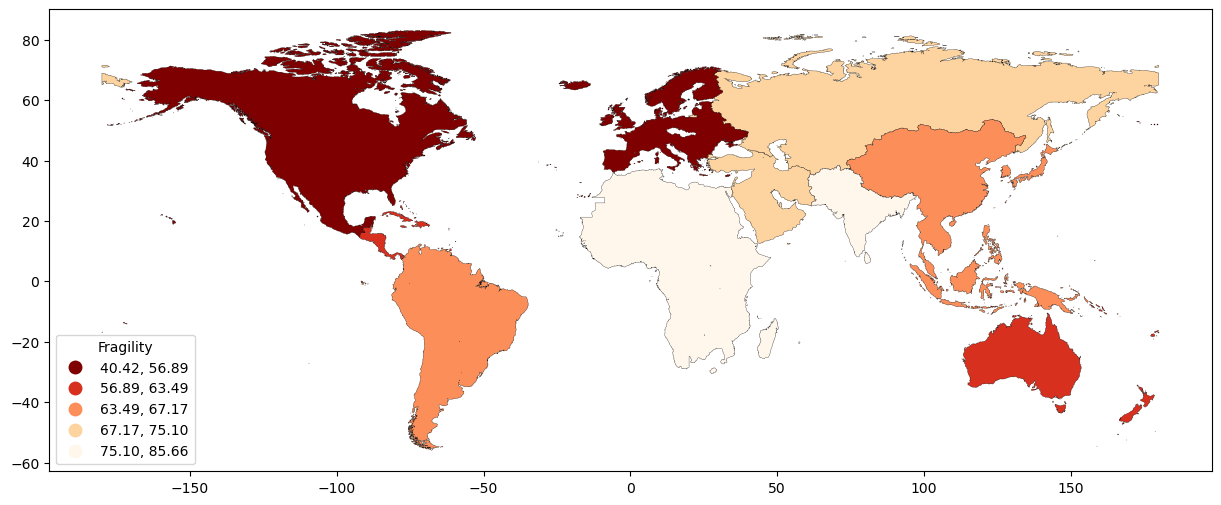

In [37]:
indicatorsByRegion.plot(column =('fragility', 'mean'),scheme='quantiles', cmap='OrRd_r',
                        legend=True,
                        legend_kwds={"title": "Fragility",'loc': 'lower left'},
                        edgecolor='black',linewidth=0.2,
                        figsize=(15, 10))

Keep in mind that the combining of objects via UNION_ALL and DISSOLVE are destructive, we can not undo them. We have operations like EXPLODE that work in the reverse direction (splitting) but even those can not undo the output of UNION_ALL and DISSOLVE. Always preserve your original GeoDataFrame before using these operations, as they permanently alter your data in ways that cannot be reversed.

In [38]:
# Italy, for example is a multipolygon
countries[countries.COUNTRY=='Italy']

,COUNTRY,geometry
108,Italy,"MULTIPOLYGON (((12.75357 43.971, 12.76472 43.9..."


<Axes: >

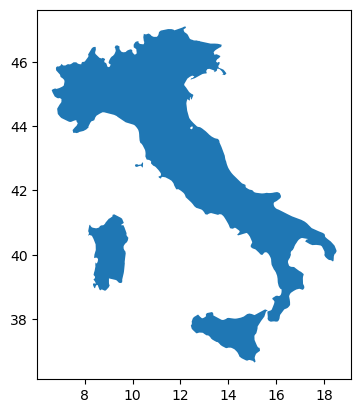

In [39]:
countries[countries.COUNTRY=='Italy'].plot()

In [40]:
# here the mainland is separated from Sardinia, and Sicily
countries[countries.COUNTRY=='Italy'].explode()

,COUNTRY,geometry
108,Italy,"POLYGON ((12.75357 43.971, 12.76472 43.97028, ..."
108,Italy,"POLYGON ((10.41861 42.70861, 10.35139 42.76125..."
108,Italy,"POLYGON ((8.36611 39.2261, 8.42417 39.26888, 8..."
108,Italy,"POLYGON ((15.08139 36.64916, 15.04375 36.68694..."


[TOC](#0)
_____________


<a class="anchor" id="4"></a>

## II. The convex hull

Some time you may have the need to create a polygon that serves as an envelope to a set of points.

For this example, let me keep the large airports:

<Axes: >

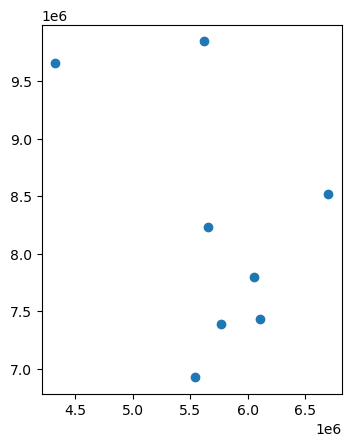

In [41]:
# just the union
airports_5880=gpd.read_file(LinkBrazil,layer='airports')
large_airport=airports_5880[airports_5880.kind=='large_airport']
large_airport.plot()

May I use now **convex_hull**?

<Axes: >

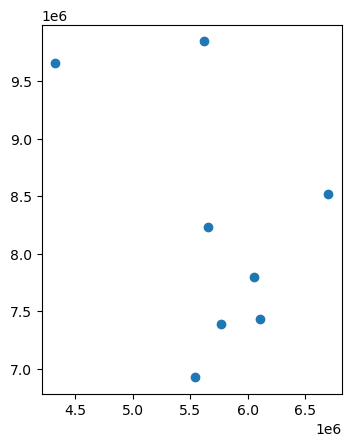

In [42]:
## you see no difference!!
large_airport.convex_hull.plot()

The objects to be enveloped required to be **combined** previously: 

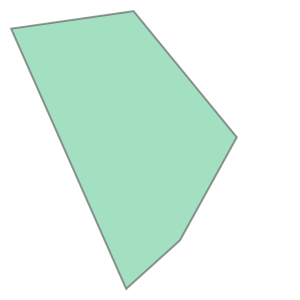

In [43]:
# hull of the union
large_airport.union_all().convex_hull

We got:

In [44]:
# this geometry not a GeoDF...yet
type(large_airport.union_all().convex_hull)

shapely.geometry.polygon.Polygon

Let's turn this geometry into a GDF:

In [45]:
LargeAirport_hull= gpd.GeoDataFrame(index=[0],
                                    crs=large_airport.crs,
                                    geometry=[large_airport.union_all().convex_hull])
LargeAirport_hull['name']='large airports hull' # optional

# then

LargeAirport_hull

,geometry,name
0,"POLYGON ((5537273.577 6926234.097, 4327494.283...",large airports hull


Let's use the GDF in plotting:

<Axes: >

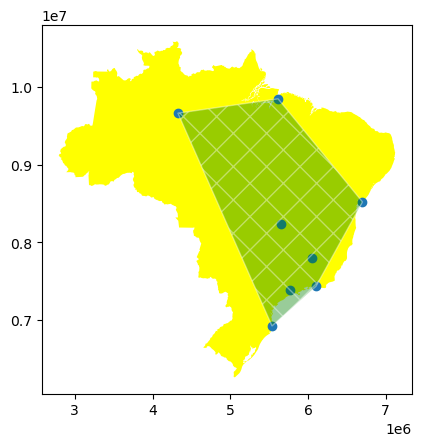

In [46]:
brazil_5880=gpd.read_file(LinkBrazil,layer='country')
base=brazil_5880.plot(facecolor='yellow')
large_airport.plot(ax=base)
LargeAirport_hull.plot(ax=base,facecolor='green',
                       edgecolor='white',alpha=0.4,
                       hatch='X')

You can get a convex hull of lines or polygons:

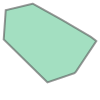

In [47]:
riversBrazil_clipped.union_all().convex_hull

You can use it for dissolved polygons:

<Axes: >

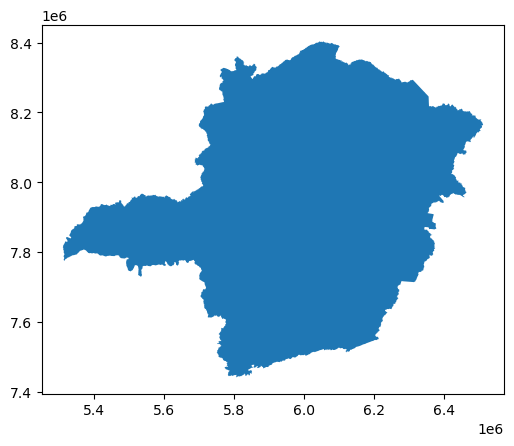

In [48]:
MinasGerais_dissolve.plot()

<Axes: >

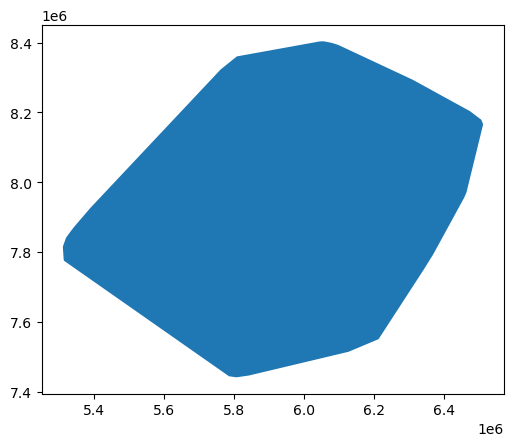

In [49]:
#then
MinasGerais_dissolve.convex_hull.plot()

Remember that **union_all** and **dissolve()** give different outputs:

In [50]:
# you got a series, not just a geometry 
type(MinasGerais_dissolve.convex_hull)

geopandas.geoseries.GeoSeries

In [51]:
# a simple "to_frame" does the job
MinasGerais_dissolve.convex_hull.to_frame()

,0
0,"POLYGON ((5806065.089 7442523.343, 5784960.152..."


In [52]:
# more details
MinasGerais_hull=MinasGerais_dissolve.convex_hull.to_frame()
MinasGerais_hull["name"]="Minas Gerais"
MinasGerais_hull.rename(columns={0:"geometry"})
MinasGerais_hull
                        

,0,name
0,"POLYGON ((5806065.089 7442523.343, 5784960.152...",Minas Gerais


In [53]:
#noticed the crs was inherired
MinasGerais_hull.crs

<Projected CRS: EPSG:5880>
Name: SIRGAS 2000 / Brazil Polyconic
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Brazil - onshore and offshore. Includes Rocas, Fernando de Noronha archipelago, Trindade, Ihlas Martim Vaz and Sao Pedro e Sao Paulo.
- bounds: (-74.01, -35.71, -25.28, 7.04)
Coordinate Operation:
- name: Brazil Polyconic
- method: American Polyconic
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

You need the union/dissolve to avoid that a hull were created  for each row (polygon here), see:

<Axes: >

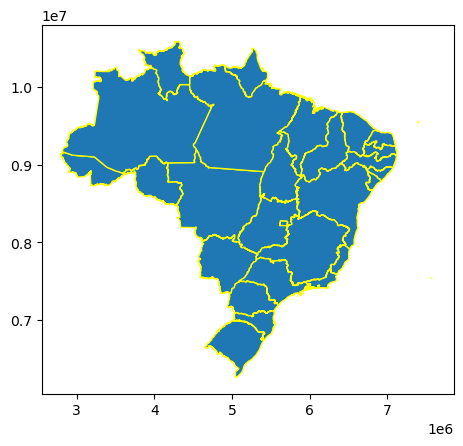

In [54]:
#original not COMBINED:
Brazil_adm1_diss.plot(edgecolor="yellow")

<Axes: >

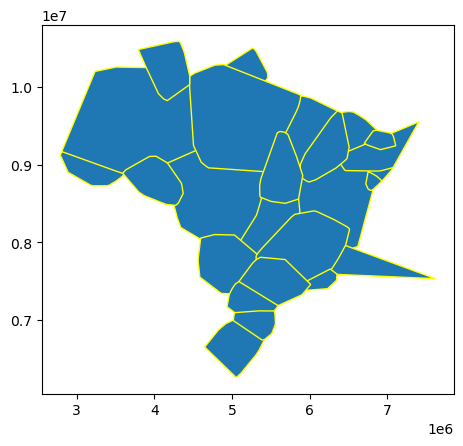

In [55]:
# hull of Non combined
Brazil_adm1_diss.convex_hull.plot(edgecolor="yellow")

<Axes: >

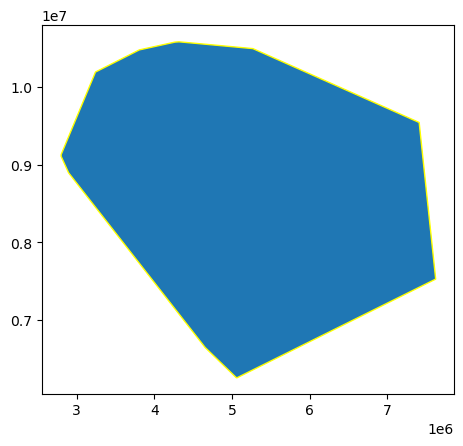

In [56]:
# the hull of Brazil
Brazil_adm1_diss.dissolve().convex_hull.plot(edgecolor="yellow")

## III. The Buffer

The buffer will create polygon that follows the same shape of the original vector (line, polygon, point).


<Axes: >

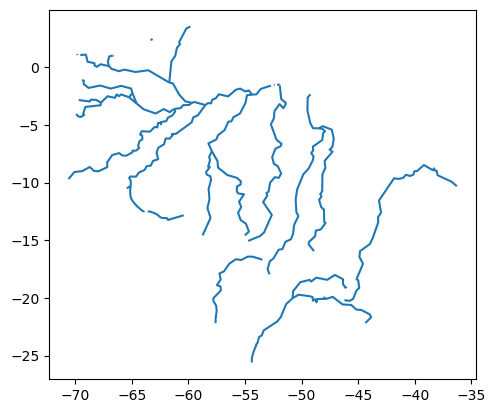

In [57]:
# this is the original
riversBrazil_clipped.plot()

But, verify crs as we are going to use distances:

In [58]:
riversBrazil_clipped.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's reproject:

In [59]:
riversBrazil_5880=riversBrazil_clipped.copy()
riversBrazil_5880 = riversBrazil_5880.to_crs('EPSG:5880')

Now I can use the rivers to create a buffer of 50000 meters:

<Axes: >

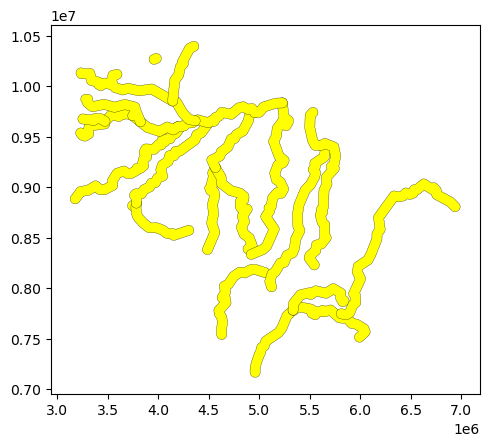

In [60]:
# 50000 at each side (radius)
riversBrazil_5880.buffer(50000).plot(facecolor='yellow', edgecolor='black',linewidth=0.2)

The resulting buffer is:

In [61]:
type(riversBrazil_5880.buffer(50000))

geopandas.geoseries.GeoSeries

Then:

<Axes: >

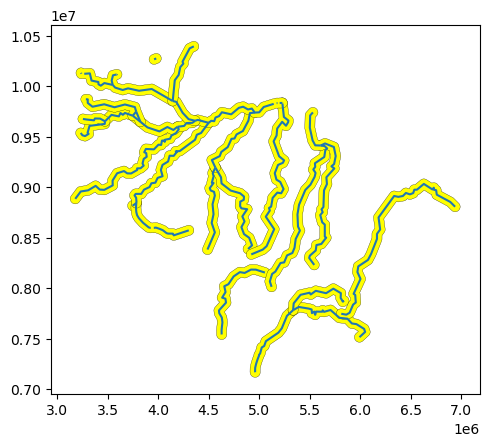

In [62]:
base=C.plot(facecolor='yellow',edgecolor='black',linewidth=0.2)
riversBrazil_5880.plot(ax=base)

notice:

<Axes: >

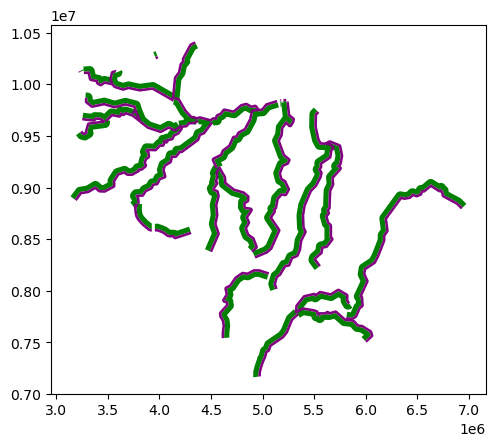

In [76]:
riv_buf_right = riversBrazil_5880.buffer(distance = 50000, single_sided = True)
riv_buf_left = riversBrazil_5880.buffer(distance = -25000, single_sided = True)

base =riv_buf_right.plot(color='green')
riv_buf_left.plot(ax=base, color='purple')

Let me save the rivers reprojected in a JSON file:

In [63]:
riversBrazil_5880.to_file("riversBrazil_5880.geojson", driver="GeoJSON")

[TOC](#0)
_____________

<a class="anchor" id="5"></a>
# BINARY Operations: Spatial Overlay

We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will se the use of _intersection_, _union_, _difference_, and _symmetric difference_.

Let me create this GeoDFs:

In [64]:
# the north
MunisN_brazil=brazil_municipalities.cx[:,centroidY:]
# the south
MunisS_brazil=brazil_municipalities.cx[:,:centroidY]
# the west
MunisW_brazil=brazil_municipalities.cx[:centroidX,:]
# the east
MunisE_brazil=brazil_municipalities.cx[centroidX:,:]

NameError: name 'centroidY' is not defined

Let me plot:

In [ ]:
base=MunisN_brazil.plot(facecolor='yellow', edgecolor='black',linewidth=0.2, alpha=0.6)
MunisS_brazil.plot(facecolor='grey', edgecolor='black',linewidth=0.2,ax=base, alpha=0.4)

In [ ]:
base=MunisE_brazil.plot(facecolor='yellow', edgecolor='black',linewidth=0.2, alpha=0.6)
MunisW_brazil.plot(facecolor='grey', edgecolor='black',linewidth=0.2,ax=base, alpha=0.4)

## Intersection

We keep what is common between GeoDFs:

In [ ]:
munisNS_brazil=MunisN_brazil.overlay(MunisS_brazil, how="intersection",keep_geom_type=True)
munisNS_brazil.plot()

In [ ]:
# keeping the overlay
munisWE_brazil=MunisW_brazil.overlay(MunisE_brazil, how="intersection",keep_geom_type=True)
munisWE_brazil.plot(edgecolor='white',linewidth=0.1)

## Union

Let me unite any polygons that touche each other. First, take a look at each one:

In [ ]:
munisNS_brazil.info()

In [ ]:
munisWE_brazil.info()

Let me subset and show you:

In [ ]:
keep=['ADM0_EN_1','ADM1_PT_1','ADM2_PT_1','geometry']
munisNS_brazil=munisNS_brazil.loc[:,keep]
munisWE_brazil=munisWE_brazil.loc[:,keep]

In [ ]:
# now
munisNS_brazil.overlay(munisWE_brazil,how="union",keep_geom_type=True)

As you see, geometries are fine, but not attributes. It is strictly NOT appending the GeoDFs:

In [ ]:
# appending
import pandas as pd

pd.concat([munisNS_brazil,munisWE_brazil],ignore_index=True)

These are different operations. UNION will combine any geometries that have overlaping portions in common.

In [ ]:
munisNS_brazil.overlay(munisWE_brazil, how="union",keep_geom_type=True)

Let me create an object to save the previous result:

In [ ]:
muniMidBrazil=munisNS_brazil.overlay(munisWE_brazil, how="union",keep_geom_type=True).dissolve()
muniMidBrazil

In [ ]:
# some cleaning

muniMidBrazil['zone']='middles'
muniMidBrazil=muniMidBrazil.loc[:,['ADM0_EN_1_1','zone','geometry']]
muniMidBrazil

## Difference

Here, you keep what belongs to the GeoDF to left that is not in the GeoDF to the right:

In [ ]:
# with the municipalities
brazil_municipalities.overlay(muniMidBrazil, how='difference').plot()

## Symmetric Difference

This is the opposite to *intersection*, you keep what is not in the intersection:

In [ ]:
MunisN_brazil.overlay(MunisS_brazil, how="symmetric_difference",keep_geom_type=True).plot()

In [ ]:
MunisW_brazil.overlay(muniMidBrazil, how="symmetric_difference",keep_geom_type=False).plot()

[TOC](#0)
_____________

<a class="anchor" id="6"></a>

# Validity of Geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
MunisS_brazil[~MunisS_brazil.is_valid]

In [ ]:
# see the invalid:
MunisS_brazil[~MunisS_brazil.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(MunisS_brazil[~MunisS_brazil.is_valid].geometry)

In [ ]:
# varieties?
MunisS_brazil['validity']=[x.split('[')[0] for x in MunisS_brazil.geometry.apply(lambda x: explain_validity(x))]
MunisS_brazil['validity'].value_counts()

In [ ]:
# solving the issue:
MunisS_brazil.drop(columns=['validity'],inplace=True)

MunisS_brazil_valid=MunisS_brazil.copy()

MunisS_brazil_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in MunisS_brazil_valid['geometry'] ]
#any invalid?
MunisS_brazil_valid[~MunisS_brazil_valid.is_valid]

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [ ]:
pd.Series([type(x) for x in MunisS_brazil_valid.geometry]).value_counts()

## Buffers and Validity

The buffering process helps cleaning simple invalidities:

In [ ]:
MunisS_brazil_valid=MunisS_brazil.copy()

MunisS_brazil_valid['geometry'] = MunisS_brazil_valid['geometry'].buffer(0)

#any invalid?
MunisS_brazil_valid[~MunisS_brazil_valid.is_valid]

Comparing with the previous result, this time you got no collections:

In [ ]:
# then:
pd.Series([type(x) for x in MunisS_brazil_valid.geometry]).value_counts()

This 'buffer trick' may not always work:

In [ ]:
# previously
indicators.dissolve(
     by="region",
     aggfunc={
         "fragility": ["mean"]},as_index=False
 ).plot(column =('fragility', 'mean'),scheme='quantiles', cmap='OrRd_r',
                        legend=True,
                        legend_kwds={"title": "Fragility",'loc': 'lower left'},
                        edgecolor='black',linewidth=0.2,
                        figsize=(15, 10))

Notice that AFRICA has some lines that should have dissappeared after dissolving, but you can still see some lines.

We could try the buffer trick:

In [ ]:
indicators_valid=indicators.copy()
indicators_valid['geometry'] = indicators_valid['geometry'].buffer(0)
dissolved_gdf=indicators_valid.dissolve(
     by="region",
     aggfunc={
         "fragility": ["mean"]},as_index=False, grid_size=0.1
 )




dissolved_gdf.plot(column =('fragility', 'mean'),scheme='quantiles', cmap='OrRd_r',
                        legend=True,
                        legend_kwds={"title": "Fragility",'loc': 'lower left'},
                        edgecolor='black',linewidth=0.2,
                        figsize=(15, 10))

It did not work either. We may use a new functionality in GeoPandas's dissolve:

In [ ]:
dissolved_gdf=indicators.dissolve(
     by="region",
     aggfunc={
         "fragility": ["mean"]},as_index=False, grid_size=0.1
 )




dissolved_gdf.plot(column =('fragility', 'mean'),scheme='quantiles', cmap='OrRd_r',
                        legend=True,
                        legend_kwds={"title": "Fragility",'loc': 'lower left'},
                        edgecolor='black',linewidth=0.2,
                        figsize=(15, 10))

Now, you do see a clean map.